# Persian Image Captioning
In this notoebook, we are going to walk through the steps of fine-tuning the [Vision Encoder Decoder Model](https://huggingface.co/docs/transformers/v4.16.2/en/model_doc/vision-encoder-decoder#transformers.VisionEncoderDecoderModel) for the task of image captioning on the [coco-flickr-farsi](https://www.kaggle.com/navidkanaani/coco-flickr-farsi) dataset. We will implement our model in PyTorch with transformers library by Hugging Face(🤗).

You can choose any pretrained vision model and any language model to use in the Vision Encoder Decoder model. Here we use [ViT](https://huggingface.co/google/vit-base-patch16-224-in21k) as the encoder, and [ParsBERT (v2.0)](https://huggingface.co/HooshvareLab/bert-fa-base-uncased-clf-persiannews) as the decoder. The encoder and decoder are loaded separately via `from_pretrained()`function. Cross-attention layers are randomly initialized and added to the decoder.

You may refer to the [Vision Encoder Decoder Model](https://huggingface.co/docs/transformers/model_doc/vision-encoder-decoder) for more information.

In [3]:
!nvidia-smi

Wed Feb 16 15:43:09 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.119.04   Driver Version: 450.119.04   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
import torch
import torchvision.transforms as transforms
import pandas as pd
import transformers
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, default_data_collator, ViTFeatureExtractor, VisionEncoderDecoderModel
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer
import matplotlib.pyplot as plt
from PIL import Image
import os
import gc
import multiprocessing

## Hyperparameters

In [5]:
#Disabling warnings
transformers.logging.set_verbosity_error()

csv_file = '../input/coco-flickr-farsi/dataset.csv'
img_dir = '../input/coco-flickr-farsi/images'

TEST_SIZE = 0.05
MAX_LEN = 30
BATCH_SIZE = 8

## Some helper functions

In [6]:
def clear_gpu():
    torch.clear_autocast_cache()
    torch.cuda.ipc_collect()
    torch.cuda.empty_cache()
    gc.collect()


def optimal_workers():
    num_cpus = multiprocessing.cpu_count()
    num_gpus = torch.cuda.device_count()
    optimal_value = min(num_cpus, num_gpus*4) if num_gpus else num_cpus - 1
    return optimal_value

def show_data(item, image):
    
    print(item['pixel_values'].shape)
    print(item['labels'].shape)
    
    #displaying an image from the training set
    plt.axis("off")
    plt.imshow(image)
    
    #displaying the caption
    labels = item['labels']
    labels[labels == -100] = tokenizer.pad_token_id
    label_str = tokenizer.decode(labels, skip_special_tokens=True)
    print(label_str)

# Preparing the data

We write our custom PersianKaggleDataset class that returns `pixel_values` and `labels` for each item of the dataset. Note that in the task of image captoning, labels are the tokenized captions. And the model we use, automatically creates the decoder_input_ids by shifting the labels one position to the right, and replaces ids with the value of -100 by the pad_token_id.

In [7]:
class PersianKaggleDataset(Dataset):
    
    def __init__(self, img_path, img_name, feature_extractor, tokenizer, caption, max_len=MAX_LEN, mode: str = 'train'):
        
        self.img_path = img_path
        self.max_len=max_len
        self.feature_extractor = feature_extractor
        self.img_name = img_name
        self.caption=caption
        self.tokenizer=tokenizer
        
        if mode == 'train':
             self.augmented = transforms.Compose([transforms.Resize((self.feature_extractor.size * 3 // 2, self.feature_extractor.size * 3 // 2)),
                              transforms.RandomHorizontalFlip(),
                              transforms.RandomCrop(self.feature_extractor.size),
                              transforms.ToTensor(),
                              transforms.Normalize(self.feature_extractor.image_mean, self.feature_extractor.image_std),])
  
        elif mode == 'test':
             self.augmented = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize(self.feature_extractor.image_mean, self.feature_extractor.image_std),])
                

    def __len__(self):
        return len(self.img_name)

    def __getitem__(self, idx):            
        image_names = self.img_name[idx]
        image = self.augmented(Image.open(self.img_path + "/" + image_names).convert("RGB"))
        pixel_values = self.feature_extractor(image, return_tensors="pt").pixel_values
            
        tokens = self.caption[idx]
        labels = self.tokenizer(tokens, padding='max_length', max_length=self.max_len, truncation=True).input_ids
        labels = [label if label != self.tokenizer.pad_token_id else -100 for label in labels]
   
        return {"pixel_values": pixel_values.squeeze(),
                "labels": torch.tensor(labels)}

We read our data, split it into train and test sets, and reset the indices of the splitted data.
We then load feature extractor and tokenizer and provide them all to the PersianKaggleDatase to prepare the training and evaluaion datasets for our model.

In [8]:
#reading and spliting the dataset
annotations_file = pd.read_csv(csv_file, header=0)
annotations_file = annotations_file.dropna()
train_df, test_df = train_test_split(annotations_file, test_size=TEST_SIZE)
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

#loading feature extractor and tokenizer
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
tokenizer = AutoTokenizer.from_pretrained('HooshvareLab/bert-fa-base-uncased-clf-persiannews')
#Depending on the decoder pretrained model you use, you might need to add special tokens to your tokenizer
tokenizer.add_special_tokens({'bos_token': '[CLS]', 'eos_token': '[SEP]', 'unk_token': '[unk]', 'pad_token': '[PAD]'})
    

    
train_ds = PersianKaggleDataset(img_dir, img_name=train_df.image.tolist(), feature_extractor=feature_extractor, tokenizer=tokenizer, caption=train_df.caption.tolist())
val_ds = PersianKaggleDataset(img_dir, img_name=test_df.image.tolist(), feature_extractor=feature_extractor, tokenizer=tokenizer, caption=test_df.caption.tolist())
    

Downloading:   0%|          | 0.00/160 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/62.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.41k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [9]:
print("Length of the train dataset:", len(train_ds))
print("Length of the evaluation dataset:", len(val_ds))

Length of the train dataset: 117957
Length of the evaluation dataset: 6209


### Showing one sample of our training dataset

torch.Size([3, 224, 224])
torch.Size([30])
ماشینی که در طول یک روز افتابی در امتداد جاده حرکت می کند.


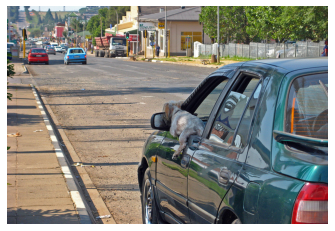

In [10]:
item = train_ds[0]

image = Image.open(img_dir + "/" +  train_df['image'][0]).convert("RGB")

show_data(item, image)

# Preparing to train
First, we initialize the Vision Encoder Decoder using a pretrained Vit model as its encoder and a pretrained Bert model as its decoder.

In [11]:
model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained('google/vit-base-patch16-224-in21k', 'HooshvareLab/bert-fa-base-uncased-clf-persiannews')

Downloading:   0%|          | 0.00/502 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/330M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/621M [00:00<?, ?B/s]

Next, we set some of the attributes in the model configuration, and beam search parameters.

In [13]:
# setting special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = tokenizer.bos_token_id
model.config.pad_token_id = tokenizer.pad_token_id
model.config.decoder.pad_token_id = tokenizer.pad_token_id

# making sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

# setting beam search parameter
model.config.eos_token_id = tokenizer.sep_token_id
model.config.max_length = 30
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4
model.decoder.resize_token_embeddings(len(tokenizer))

# freezing the encoder
for param in model.encoder.parameters():
    param.requires_grad = False

Here we choose to use `Seq2SeqTrainer`, a subclass of `Trainer` that allows us to compute BLEU, a generative metric in the evaluation loop, accordingly, we use `Seq2SeqTrainingArguments` to define some of the training hyperparameters.


In [14]:
training_args = Seq2SeqTrainingArguments(
    "Persian-Image-Captioning",
    predict_with_generate=True, 
    evaluation_strategy="steps", 
    save_strategy="steps",
    per_device_train_batch_size=8, 
    per_device_eval_batch_size=8, 
    overwrite_output_dir=False, 
    #output_dir=output_dir, 
    fp16=True, 
    learning_rate=4e-5,
    num_train_epochs = 2,
    load_best_model_at_end=True,
    logging_steps=3500,
    eval_steps=3500,
    save_steps=7000,
    report_to="none",
    disable_tqdm=False,
)

# Training our model
The `default_data_collator` is provided to our trainer.

In case you decide to pause and resume the trainig, comment `trainer.train()`, and uncomment `trainer.train(resume_from_checkpoint=True)` 

In [15]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"
clear_gpu()
training_args.dataloader_num_workers = optimal_workers()
    # instantiating our trainer
trainer = Seq2SeqTrainer(
        model=model,
        tokenizer=feature_extractor,
        args=training_args,
        train_dataset=train_ds,
        eval_dataset=val_ds,
        data_collator=default_data_collator,
)
trainer.train()
#trainer.train(resume_from_checkpoint=True)

Cloning https://huggingface.co/MahsaShahidi/Persian-Image-Captioning into local empty directory.
Using amp fp16 backend
***** Running training *****
  Num examples = 117957
  Num Epochs = 2
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 29490
/opt/conda/lib/python3.7/site-packages/transformers/modeling_utils.py:384: UserWarning: Could not estimate the number of tokens of the input, floating-point operations will not be computed
  "Could not estimate the number of tokens of the input, floating-point operations will not be computed"


Step,Training Loss,Validation Loss
3500,3.486100,2.984294
7000,2.885400,2.765638
10500,2.701000,2.633736
14000,2.627900,2.567979
17500,2.478200,2.517924
21000,2.432100,2.483771
24500,2.387600,2.451301
28000,2.385400,2.429973


***** Running Evaluation *****
  Num examples = 6209
  Batch size = 8
/opt/conda/lib/python3.7/site-packages/transformers/trainer.py:1357: FutureWarning: Non-finite norm encountered in torch.nn.utils.clip_grad_norm_; continuing anyway. Note that the default behavior will change in a future release to error out if a non-finite total norm is encountered. At that point, setting error_if_nonfinite=false will be required to retain the old behavior.
  args.max_grad_norm,
***** Running Evaluation *****
  Num examples = 6209
  Batch size = 8
Saving model checkpoint to Persian-Image-Captioning/checkpoint-7000
Configuration saved in Persian-Image-Captioning/checkpoint-7000/config.json
Model weights saved in Persian-Image-Captioning/checkpoint-7000/pytorch_model.bin
Configuration saved in Persian-Image-Captioning/checkpoint-7000/preprocessor_config.json
Configuration saved in Persian-Image-Captioning/preprocessor_config.json
/opt/conda/lib/python3.7/site-packages/transformers/modeling_utils.py:38

# Inference on a new image

loading configuration file ./Persian-Image-Captioning/checkpoint-28000/config.json
Model config VisionEncoderDecoderConfig {
  "architectures": [
    "VisionEncoderDecoderModel"
  ],
  "decoder": {
    "_name_or_path": "HooshvareLab/bert-fa-base-uncased-clf-persiannews",
    "add_cross_attention": true,
    "architectures": [
      "BertForSequenceClassification"
    ],
    "attention_probs_dropout_prob": 0.1,
    "bad_words_ids": null,
    "bos_token_id": null,
    "chunk_size_feed_forward": 0,
    "classifier_dropout": null,
    "cross_attention_hidden_size": null,
    "decoder_start_token_id": null,
    "diversity_penalty": 0.0,
    "do_sample": false,
    "early_stopping": false,
    "encoder_no_repeat_ngram_size": 0,
    "eos_token_id": null,
    "finetuning_task": "persiannews",
    "forced_bos_token_id": null,
    "forced_eos_token_id": null,
    "gradient_checkpointing": false,
    "hidden_act": "gelu",
    "hidden_dropout_prob": 0.1,
    "hidden_size": 768,
    "id2label": {
 

گروهی از مردم در حال پرواز بادبادک در یک زمین چمنزار.


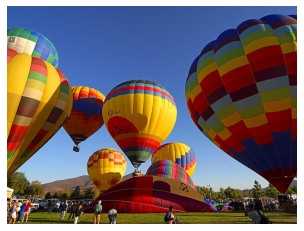

In [19]:
import urllib
import PIL


def show_img(image):
    # show image
    plt.axis("off")
    plt.imshow(image)
    
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'


#pass the url of any image to generate a caption for it    
urllib.request.urlretrieve("https://upload.wikimedia.org/wikipedia/commons/thumb/f/fd/Luftballong.jpg/800px-Luftballong.jpg", "sample.png")
image = PIL.Image.open("sample.png")


#now load the model you trained for inference 
model_checkpoint = './Persian-Image-Captioning/checkpoint-28000'
model = VisionEncoderDecoderModel.from_pretrained(model_checkpoint).to(device)

feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
tokenizer = AutoTokenizer.from_pretrained('HooshvareLab/bert-fa-base-uncased-clf-persiannews')

sample = feature_extractor(image, return_tensors="pt").pixel_values.to(device)
caption_ids = model.generate(sample, max_length = 30)[0]
caption_text = tokenizer.decode(caption_ids, skip_special_tokens=True)
print(caption_text)
show_img(image)